In [1]:
import os
import pickle

import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn

from models.forward import ForwardDiffusion
from models.reverse import ReverseDiffusion

%load_ext autoreload
%autoreload 2

In [2]:
def transform_CHW(img):
    img -= img.min()
    img /= img.max()
    return img.permute(1, 2, 0)

## Data

In [3]:
trucks = torch.load('trucks.pt').float() * 2 / 255 - 1

## Diffusion Processes

In [7]:
T = 500

forward = ForwardDiffusion(
    noise_param=(0.0001, 0.004), 
    T=T, 
    schedule='linear'
)

reverse = ReverseDiffusion(
    T=T, 
    time_embedding_dim=32, 
    time_n=512
).eval()

print(f'{sum(p.numel() for p in reverse.parameters() if p.requires_grad)} parameters')

598537 parameters


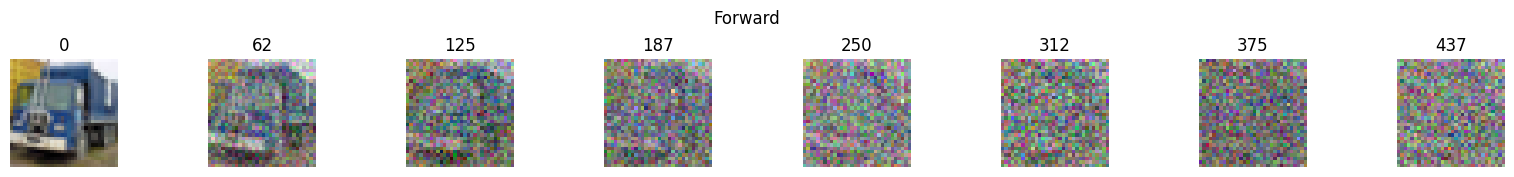

In [5]:
fig, axs = plt.subplots(1, 8, figsize=(16, 2))

fig.suptitle('Forward')
fig.tight_layout()

x = trucks[1]

for i in range(8):
    t = T * i // 8
    noised = forward(x, 0, t)
    axs[i].axis('off')
    axs[i].set_title(f'{t}')
    axs[i].imshow(transform_CHW(noised))